### Polytropic atmosphere
Here we calculate the Love number for a planet with a solid core and an atmosphere that obeys the $n=2$ polytropic equation of state $P=K\rho^2$. We use the equation for $\rho_\mathrm{atm}(r)$ from Stroch & Lai, where we solve for a value of $K$ that gives us an atmosphere with the same mass as a homogeneous atmosphere with density $\rho_\mathrm{atm}$ of the same extent. Then we run ALMA with 5 layers (1 core layer, 4 atmospheric layers) with varying densities. More layers are not possible, as ALMA becomes numerically unstable

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from src.ALMApy import run_alma, change_param
from scipy.optimize import root_scalar
from datetime import datetime


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

In [4]:
G = 6.67e-11
# Dimensions
R_jupiter = 69.9e6
m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)
m_jupiter = 1.898e27

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21

In [5]:
def get_densities(K, R_core, R, rho_atm, rho_core, no_layers):
    M_atm = 4*np.pi/3*(R**3-R_core**3)*rho_atm # Target atmosphere density
    Mp = M_atm + 4*np.pi/3*R_core**3*rho_core

    q = np.sqrt(2*np.pi*G*R**2/K)
    rho0 = q**2*Mp/(4*np.pi*R**3)
    r = np.linspace(R_core, R, no_layers)
    rho = rho0*np.sin(q*(1-r/R)/(q*r/R))
    return r, rho

In [6]:
def find_K(K, R_core, R, rho_atm, rho_core):
    M_atm = 4*np.pi/3*(R**3-R_core**3)*rho_atm # Target atmosphere density
    Mp = 4*np.pi/3*R_core**3*rho_core + M_atm

    q = np.sqrt(2*np.pi*G*R**2/K)
    rho0 = q**2*Mp/(4*np.pi*R**3)
    r = np.linspace(R_core, R, 100)
    
    dr = r[1]-r[0]
    rho = rho0*np.sin(q*(1-r/R)/(q*r/R))
    dM = 4*np.pi/3*(r[1:]**3-r[:-1]**3)*rho[:-1]
    M = np.sum(dM)
    return M-M_atm


In [20]:
R_core = R_neptune
rho_core = rho_neptune
R_max = R_jupiter*10
rho_atm = rho_air

no_layers = 10
no_steps = 100
k2_array = np.zeros(no_steps)
R_array = np.logspace(np.log10(R_core), np.log10(R_max), no_steps)

K_array = np.zeros(no_steps)

for i in range(no_steps):
    sol = root_scalar(find_K, args=(R_core, R_array[i], rho_atm, rho_core), x0=1e7)
    K_array[i] = sol.root
    

/home/nielssw/astrovaria/astrovaria_env/lib/python3.12/site-packages/scipy/optimize/_root_scalar.py:327: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=None,
/tmp/ipykernel_35912/3013371598.py:5: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt(2*np.pi*G*R**2/K)


In [21]:
rerun_sim = False
if rerun_sim:
    change_param("no_digits", 256)
    change_param("gaver_sequence_order", 16)


    start = datetime.now()
    for i in range(no_steps):
        r, rho = get_densities(K_array[i], R_core, R_array[i], rho_atm, rho_core, no_layers)

        radii = np.flip(r).tolist()
        densities = np.flip(rho).tolist()
        densities[:-1] = densities[1:]
        densities[-1] = rho_core

        t,k = run_alma(radii = radii,
                    densities = densities,
                    rigidities = [rigidity_air]*(no_layers-1)+[rigidity_earth],
                    viscosities = [viscosity_air]*(no_layers-1)+[viscosity_earth],
                    model_types = ["newton"]*(no_layers-1)+["maxwell"],
                    show_start_stop=False,
                    show_output = False)
        k2_array[i] = k[0]
        print(f"{i+1} of {no_steps} done. k2={k[0]:.3f}, eta={(datetime.now()-start)/(i+1)*(no_steps-i-1)}", end="\r")

    # reset default values
    change_param("no_digits", 128)
    change_param("gaver_sequence_order", 8)

    np.savez("polytrope_data", R_array=R_array, k2_array=k2_array, R_core=R_core, rho_core=rho_core, rho_atm=rho_atm)
else:
    data = np.load("polytrope_data")
    k2_array = data.k2_array
    R_array = data.R_array


There was an error running the command:0850

Program received signal SIGSEGV: Segmentation fault - invalid memory reference.

Backtrace for this error:
#0  0x733d92023e59 in ???
#1  0x733d92022e75 in ???
#2  0x733d91c4532f in ???
#3  0x5f1e3e81b33e in __fmzm_1_MOD_fm_input_error
#4  0x5f1e3e81c362 in __fmzm_1_MOD_fm_undef_inp_zm0
#5  0x5f1e3e83beaa in __fmzm_2_MOD_fmeq_zmzm
#6  0x5f1e3e918d0e in lubksb_
#7  0x5f1e3e9176d7 in love_numbers_
#8  0x5f1e3e908f25 in MAIN__
#9  0x5f1e3e90b203 in main

There was an error running the command:1844

Program received signal SIGSEGV: Segmentation fault - invalid memory reference.

Backtrace for this error:
#0  0x75683ce23e59 in ???
#1  0x75683ce22e75 in ???
#2  0x75683ca4532f in ???
#3  0x5cf396e6833e in __fmzm_1_MOD_fm_input_error
#4  0x5cf396e69362 in __fmzm_1_MOD_fm_undef_inp_zm0
#5  0x5cf396e88eaa in __fmzm_2_MOD_fmeq_zmzm
#6  0x5cf396f65d0e in lubksb_
#7  0x5cf396f646d7 in love_numbers_
#8  0x5cf396f55f25 in MAIN__
#9  0x5cf396f58203 in main



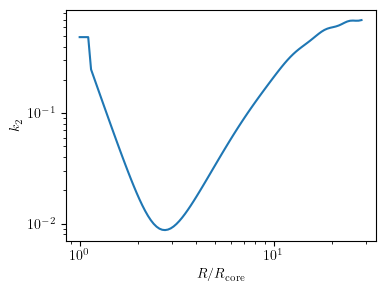

In [22]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(R_array/R_core, k2_array)
ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

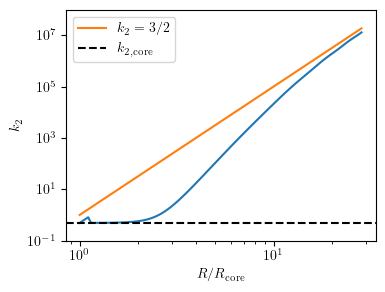

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(R_array/R_core, k2_array*(R_array/R_core)**5)
ax.plot(R_array/R_core, (R_array/R_core)**5, label="$k_2=3/2$")
ax.axhline(3/(2*(1+19*rigidity_earth/(2*rho_core*R_core*4*np.pi*G/3*rho_core*R_core))), color="black", linestyle="--", label="$k_{2,\\mathrm{core}}$")
ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.show()